In [11]:
import sys
from pathlib import Path
import pandas as pd
from io import StringIO
from ast import literal_eval
import os
import pandas as pd
import matplotlib.pyplot as plt
    
source = '../../../outputs/haider_en_experiment/'

In [7]:
df_anno = pd.read_csv('./poems.csv')

In [24]:
len(df_anno)

1240

In [18]:
valid_emotions = {
    'annoyance': 'Annoyance',
    'awe/sublime': 'Awe / Sublime',
    'awe': 'Awe / Sublime',
    'sublime': 'Awe / Sublime',
    'beauty/joy': 'Beauty / Joy',
    'beauty': 'Beauty / Joy',
    'joy': 'Beauty / Joy',
    'humor': 'Humor',
    'nostalgia': 'Nostalgia',
    'sadness': 'Sadness',
    'suspense': 'Suspense',
    'uneasiness': 'Uneasiness',
    'vitality': 'Vitality'
}

# Function to normalize and map emotions
def normalize_emotion(emotion):
    if emotion:
        emotion = emotion.lower().replace(' ', '')
        return valid_emotions.get(emotion, None)
    return None

860


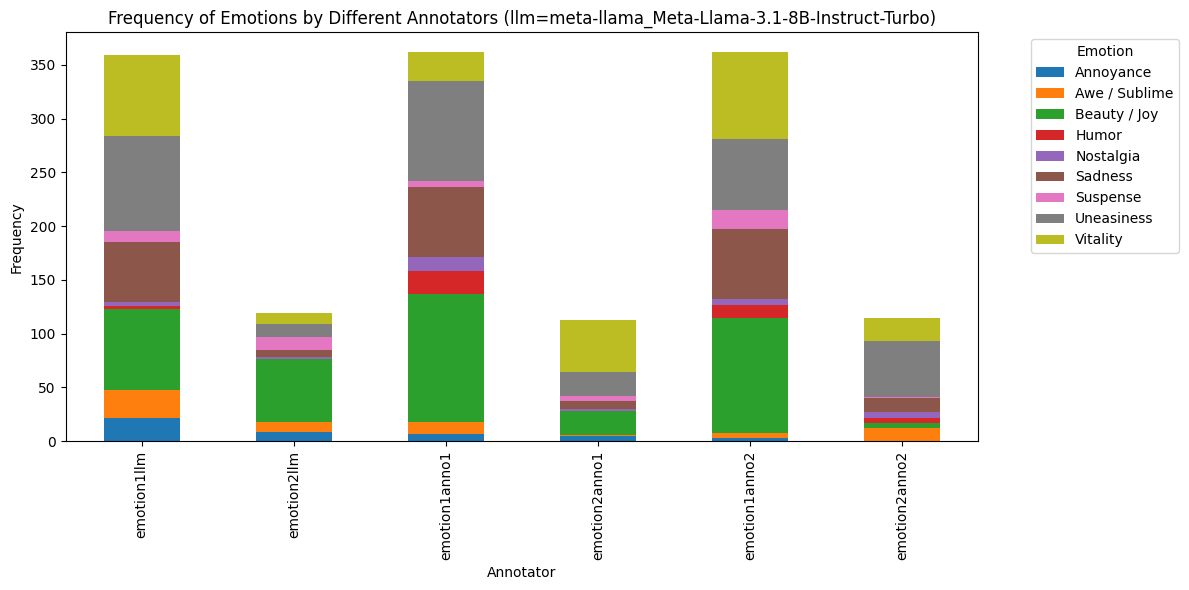

814


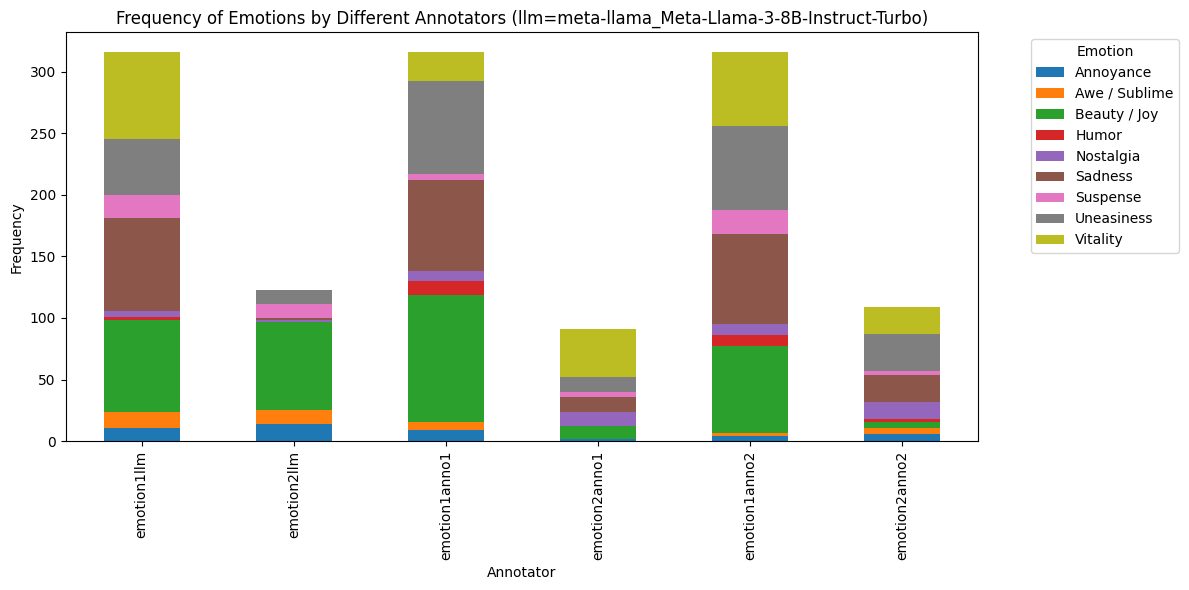

724


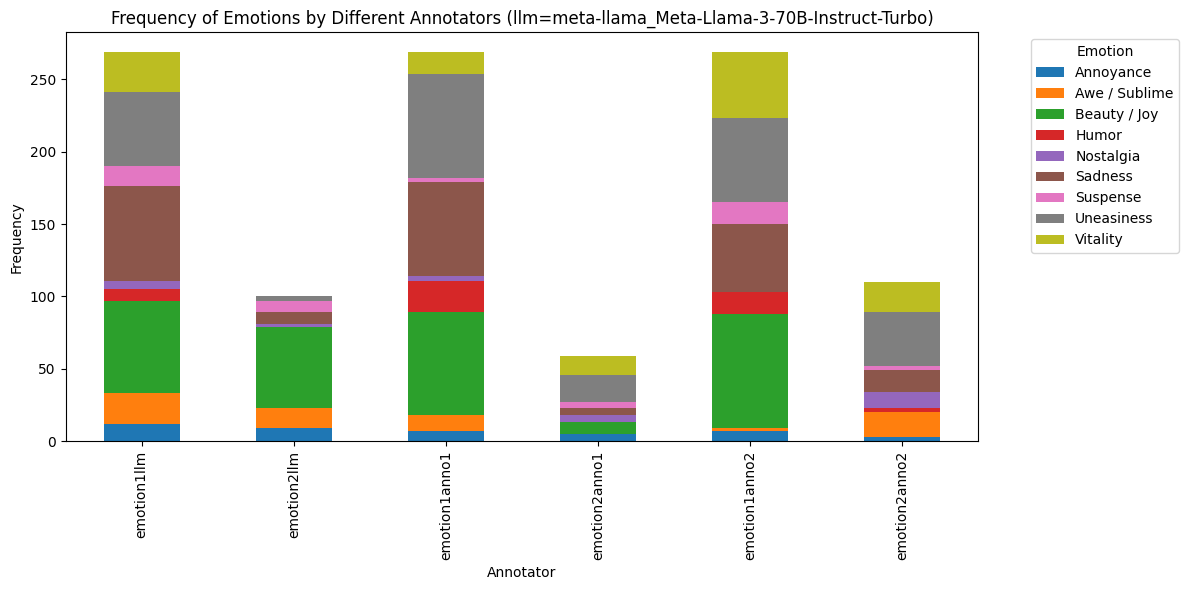

871


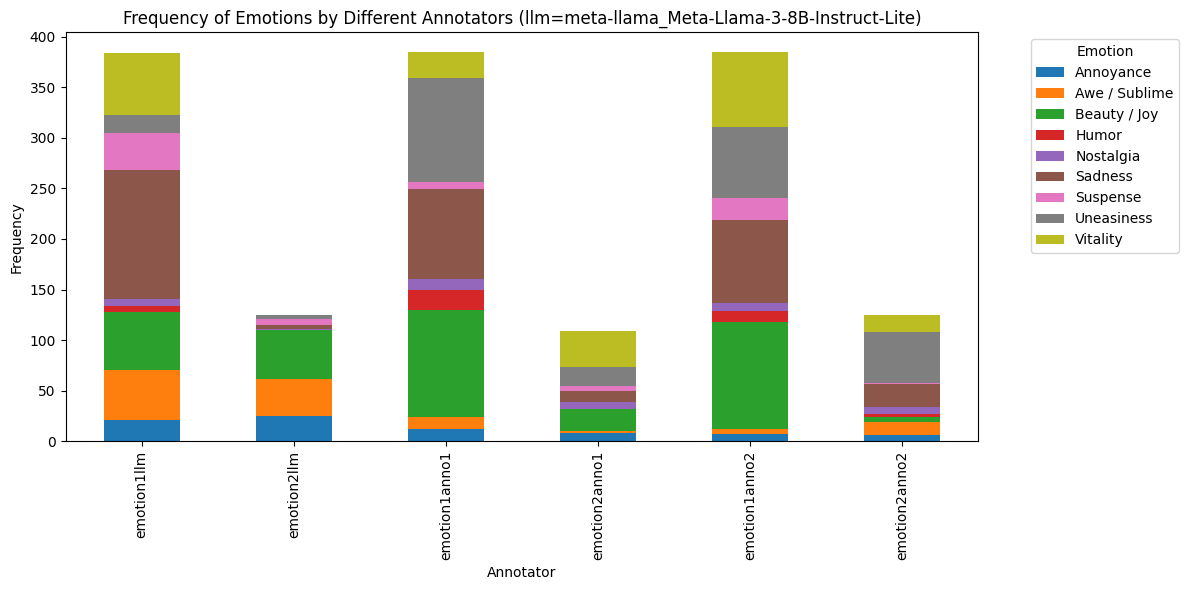

735


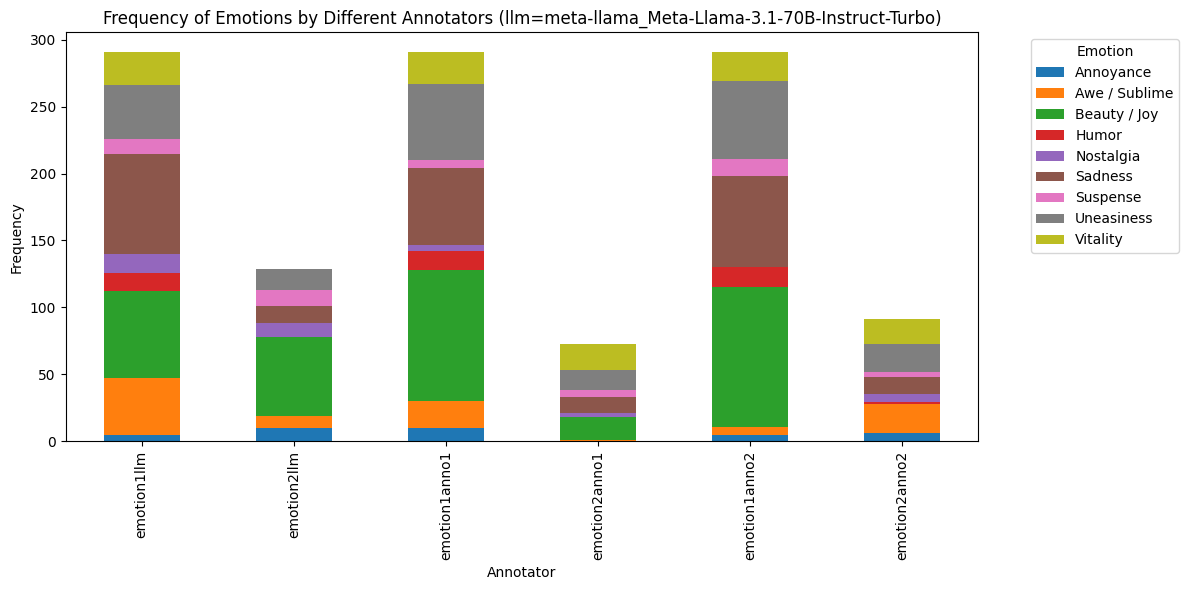

699


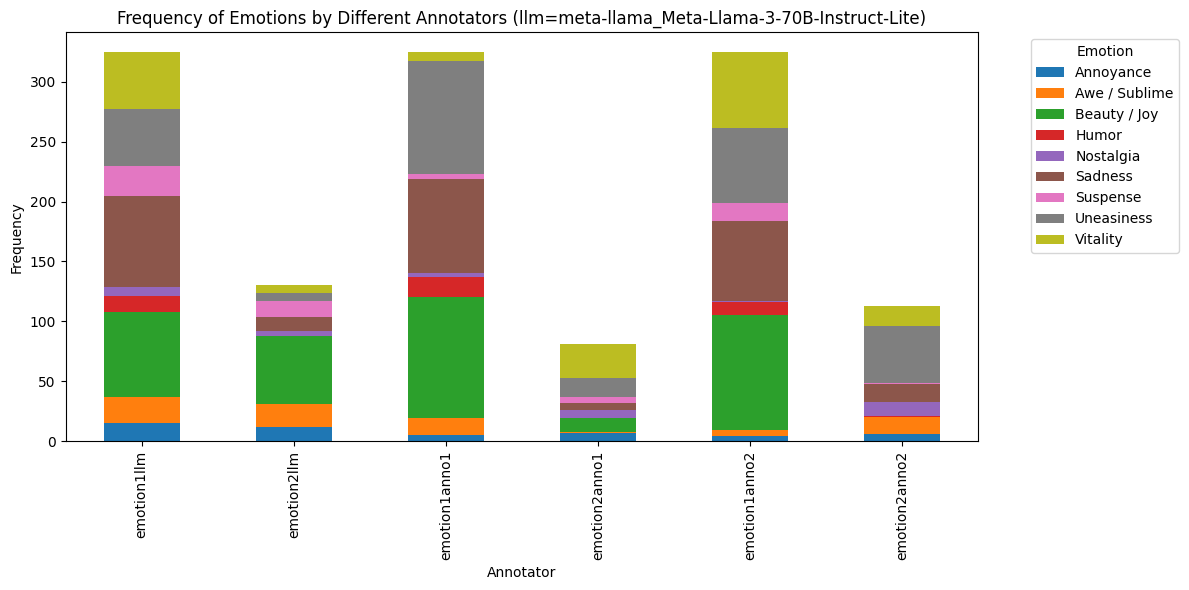

In [23]:
# Traverse through the directory to find CSV files
for root, _, files in os.walk(source):
    for file in files:
        if file.endswith(".csv"):
            # Create a new DataFrame to store the restructured data
            new_data = []
            # Read the CSV file
            file_path = os.path.join(root, file)
            # Split the path into parts
            path_parts = file_path.split(os.sep)

            # Extract the desired part
            extracted_part = os.path.join(*path_parts[4:8])

            # print(extracted_part)
            # Read the CSV data into a DataFrame
            df = pd.read_csv(file_path)

            # Parse the response column
            df['response'] = df['response'].apply(literal_eval)

            for _, row in df.iterrows():
                title = row['version']
                for stanza_id, stanza in row['response'].items():
                    for line_id, emotions in enumerate(stanza):
                        try:
                            emotion1 = normalize_emotion(emotions['emotion1'])
                            emotion2 = normalize_emotion(emotions['emotion2'])
                            new_data.append({
                                'stanza_id': int(stanza_id),
                                'line_id': line_id,
                                'title': title,
                                'emotion1llm': emotion1,
                                'emotion2llm': emotion2
                            })
                        except Exception as e:
                            continue
            print(len(new_data))

            # Create the new DataFrame
            new_df = pd.DataFrame(new_data)

            # Sort the DataFrame by title, stanza_id, and line_id
            new_df = new_df.sort_values(['title', 'stanza_id', 'line_id'])

            # Reset the index
            new_df = new_df.reset_index(drop=True)

            # Display the first few rows of the new DataFrame
            # print(new_df.head(10))

            joined_df = pd.merge(new_df, df_anno, on=['title', 'stanza_id', 'line_id'], how='inner', suffixes=('_llm', '_anno'))

            # print(joined_df.head())
            columns_to_select = ['line_id', 'emotion1llm', 'emotion2llm', 'emotion1anno1', 'emotion2anno1', 'emotion1anno2', 'emotion2anno2']
            selected_rows = joined_df[columns_to_select]

            melted_df = selected_rows.melt(id_vars=['line_id'], 
                    value_vars=['emotion1llm', 'emotion2llm', 'emotion1anno1', 'emotion2anno1', 'emotion1anno2', 'emotion2anno2'],
                    var_name='annotator', value_name='emotion')

            # Dropping NaN values
            melted_df = melted_df.dropna(subset=['emotion'])

            # Counting emotions for each annotator
            emotion_counts = melted_df.groupby(['annotator', 'emotion']).size().unstack(fill_value=0)

            # Renaming columns for clarity
            emotion_counts.columns.name = 'Emotion'

            # Specify the desired order of annotators
            desired_order = ['emotion1llm', 'emotion2llm', 'emotion1anno1', 'emotion2anno1', 'emotion1anno2', 'emotion2anno2']

            full_index = pd.Index(desired_order, name='annotator')
            emotion_counts = emotion_counts.reindex(full_index, fill_value=0)

            # Reorder the index based on the desired order
            emotion_counts = emotion_counts.loc[desired_order]

            # Creating the stacked bar chart
            ax = emotion_counts.plot(kind='bar', stacked=True, figsize=(12, 6))
            llm = extracted_part.split('/')[-1]
            plt.title(f'Frequency of Emotions by Different Annotators (llm={llm})')
            plt.xlabel('Annotator')
            plt.ylabel('Frequency')
            plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()

In [27]:
# Define the title and stanza_id you want to filter
filter_title = 'The White Man"s Burden'
filter_stanza_id = 1
columns_to_select = ['line_id', 'emotion1llm', 'emotion2llm', 'emotion1anno1', 'emotion2anno1', 'emotion1anno2', 'emotion2anno2']

# Select rows where the title and stanza_id match

selected_rows = joined_df[(joined_df['title'] == filter_title) & (joined_df['stanza_id'] == filter_stanza_id)][columns_to_select]

# Display the result
print(selected_rows)

   line_id emotion1llm emotion2llm emotion1anno1 emotion2anno1 emotion1anno2  \
0        1  Uneasiness        None    Uneasiness           NaN      Vitality   
1        2  Uneasiness        None    Uneasiness           NaN      Vitality   
2        3     Sadness        None    Uneasiness           NaN      Vitality   
3        4    Suspense        None    Uneasiness           NaN      Vitality   
4        5    Suspense        None    Uneasiness           NaN      Vitality   
5        6  Uneasiness        None    Uneasiness           NaN      Vitality   
6        7  Uneasiness     Sadness    Uneasiness           NaN      Vitality   

  emotion2anno2  
0    Uneasiness  
1    Uneasiness  
2    Uneasiness  
3    Uneasiness  
4    Uneasiness  
5    Uneasiness  
6    Uneasiness  


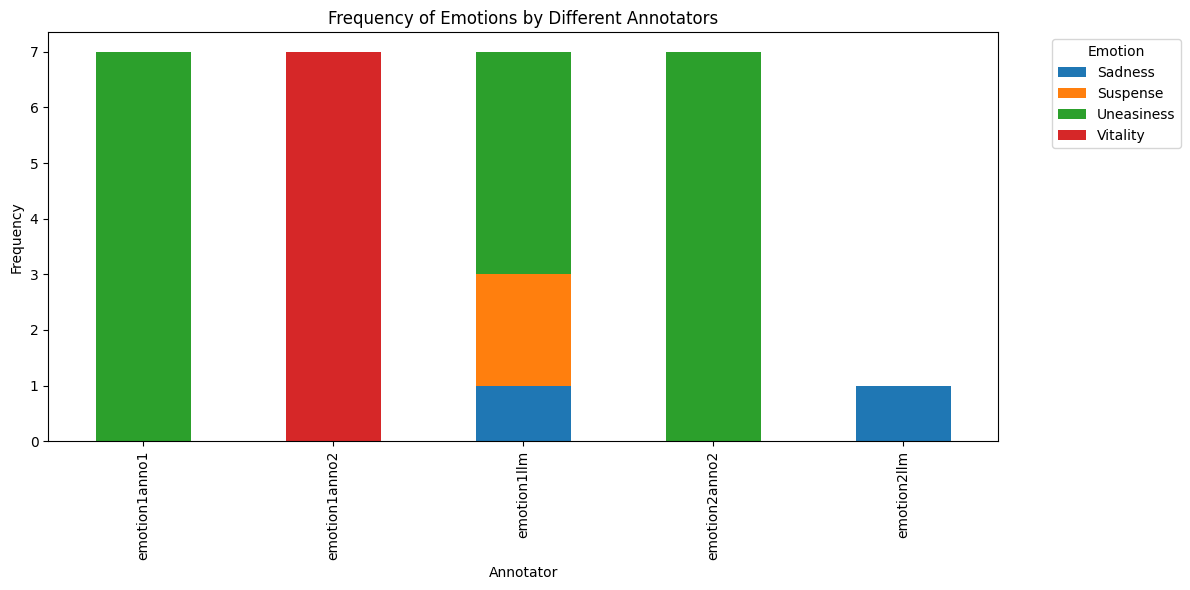

In [36]:


# Assuming your DataFrame is named 'df'

# Melting the DataFrame
melted_df = selected_rows.melt(id_vars=['line_id'], 
                    value_vars=['emotion1llm', 'emotion2llm', 'emotion1anno1', 'emotion2anno1', 'emotion1anno2', 'emotion2anno2'],
                    var_name='annotator', value_name='emotion')

# Dropping NaN values
melted_df = melted_df.dropna(subset=['emotion'])

# Counting emotions for each annotator
emotion_counts = melted_df.groupby(['annotator', 'emotion']).size().unstack(fill_value=0)

# Renaming columns for clarity
emotion_counts.columns.name = 'Emotion'
# emotion_counts.index = emotion_counts.index.str.replace('emotion1', '').str.replace('emotion2', '')

# Creating the stacked bar chart
ax = emotion_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Frequency of Emotions by Different Annotators')
plt.xlabel('Annotator')
plt.ylabel('Frequency')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

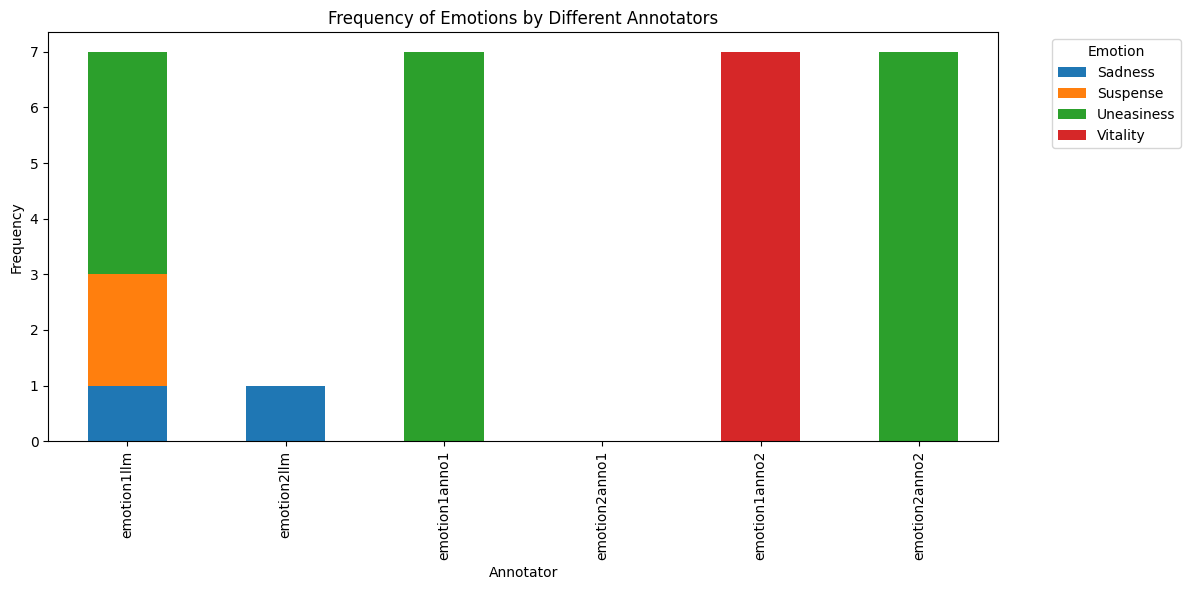

In [45]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your DataFrame is named 'df'

# Melting the DataFrame
melted_df = selected_rows.melt(id_vars=['line_id'], 
                    value_vars=['emotion1llm', 'emotion2llm', 'emotion1anno1', 'emotion2anno1', 'emotion1anno2', 'emotion2anno2'],
                    var_name='annotator', value_name='emotion')

# Dropping NaN values
melted_df = melted_df.dropna(subset=['emotion'])

# Counting emotions for each annotator
emotion_counts = melted_df.groupby(['annotator', 'emotion']).size().unstack(fill_value=0)

# Renaming columns for clarity
emotion_counts.columns.name = 'Emotion'

# Specify the desired order of annotators
desired_order = ['emotion1llm', 'emotion2llm', 'emotion1anno1', 'emotion2anno1', 'emotion1anno2', 'emotion2anno2']

full_index = pd.Index(desired_order, name='annotator')
emotion_counts = emotion_counts.reindex(full_index, fill_value=0)

# Reorder the index based on the desired order
emotion_counts = emotion_counts.loc[desired_order]

# Creating the stacked bar chart
ax = emotion_counts.plot(kind='bar', stacked=True, figsize=(12, 6))

plt.title('Frequency of Emotions by Different Annotators')
plt.xlabel('Annotator')
plt.ylabel('Frequency')
plt.legend(title='Emotion', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()